<a href="https://colab.research.google.com/github/garestrear/poligonal_clusterization/blob/construction/poligonal_clusterization_kmeans_with_SSPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## K-Means Implementation with numpy and using other distances

K-Means is a very simple clustering algorithm (clustering belongs to unsupervised learning). Given a fixed number of clusters and an input dataset the algorithm tries to partition the data into clusters such that the clusters have high intra-class similarity and low inter-class similarity. 

### Algorithm

1. Initialize the cluster centers, either randomly within the range of the input data or (recommended) with some of the existing training examples

2. Until convergence  

   2.1. Assign each datapoint to the closest cluster. The distance between a point and cluster center is measured using diferents distances.  

   2.2. Update the current estimates of the cluster centers by setting them to the mean of all instance belonging to that cluster  
   
   
### Objective function

The underlying objective function tries to find cluster centers such that, if the data are partitioned into the corresponding clusters, distances between data points and their closest cluster centers become as small as possible.

Given a set of datapoints ${x_1, ..., x_n}$ and a positive number $k$, find the clusters $C_1, ..., C_k$ that minimize

\begin{equation}
J = \sum_{i=1}^n \, \sum_{j=1}^k \, z_{ij} \, || x_i - \mu_j ||_2
\end{equation}

where:  
- $z_{ij} \in \{0,1\}$ defines whether of not datapoint $x_i$ belongs to cluster $C_j$
- $\mu_j$ denotes the cluster center of cluster $C_j$
- $|| \, ||_2$ denotes the Euclidean distance

### Disadvantages of K-Means
- The number of clusters has to be set in the beginning
- The results depend on the inital cluster centers
- It's sensitive to outliers
- It's not suitable for finding non-convex clusters
- It's not guaranteed to find a global optimum, so it can get stuck in a local minimum
- ...

In [ ]:
%matplotlib inline

In [ ]:
!pip install traj_dist

### Implementation

In [ ]:
# %load kmeans.py
import numpy as np
import traj_dist.distance as tdist
import numpy.matlib
class KMeans:
    
    def __init__(self, n_clusters=4):
        self.K = n_clusters
        
    def fit(self, X):
        self.centroids = X[np.random.choice(len(X), self.K, replace=False)]
        self.intial_centroids = self.centroids
        self.prev_label,  self.labels = None, np.zeros(len(X))
        while not np.all(self.labels == self.prev_label) :
            self.prev_label = self.labels
            self.labels = self.predict(X)
            self.update_centroid(X)
        return self
        
    def predict(self, X):
        #return np.apply_along_axis(self.compute_label, 1, X)
        return np.apply_along_axis(self.compute_label, 1, X)


    def compute_label(self, x):
        k = len(self.centroids)
        l=int(np.round(len(x)/2))
        Tc=[]
        for i in range(k):
          ac=np.array(self.centroids[i,:l])
          bc=np.array(self.centroids[i,l:])
          traj=np.transpose(np.array([ac,bc]))
          Tc.append(traj)
        x2=numpy.matlib.repmat(x,k,1)
        Tx=[]
        for i in range(k):
          ax2=np.array(x2[i,:l])
          bx2=np.array(x2[i,l:])
          traj=np.transpose(np.array([ax2,bx2]))
          Tx.append(traj)
        cdist = tdist.cdist(Tc, Tx, metric="sspd")
        ind = np.unravel_index(np.argmin(cdist, axis=None), cdist.shape)
        return ind[0]
        #return np.argmin(tdist.cdist(self.centroids, x, metric="sspd"),axis=1)
    def update_centroid(self, X):
        self.centroids = np.array([np.mean(X[self.labels == k], axis=0)  for k in range(self.K)])

### Evaluation

Automatically created module for IPython interactive environment


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


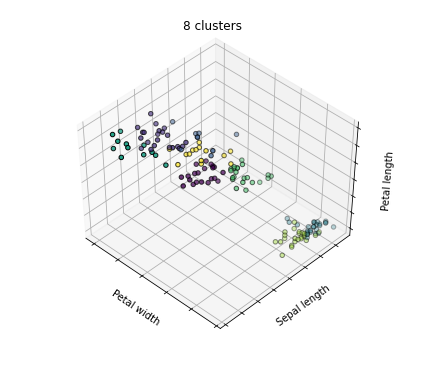

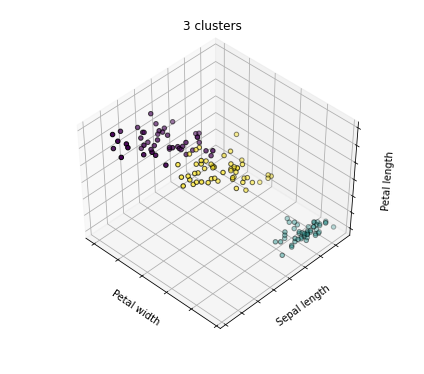

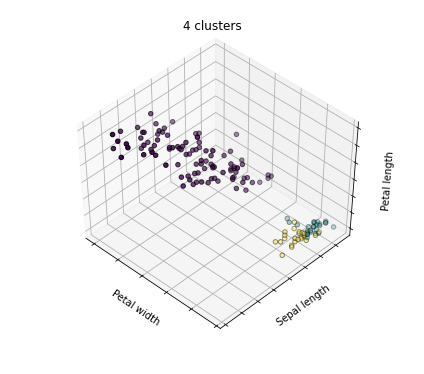

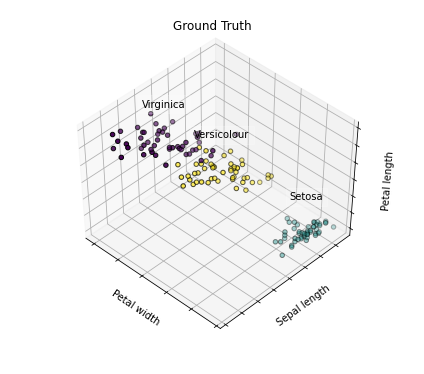

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=3)),
              ('k_means_iris_4', KMeans(n_clusters=4))]

fignum = 1
titles = ['8 clusters', '3 clusters', '4 clusters']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(6, 5))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels

    ax.scatter(X[:, 3], X[:, 0], X[:, 2],
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(6, 5))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Ground Truth')
ax.dist = 12

fig.show()

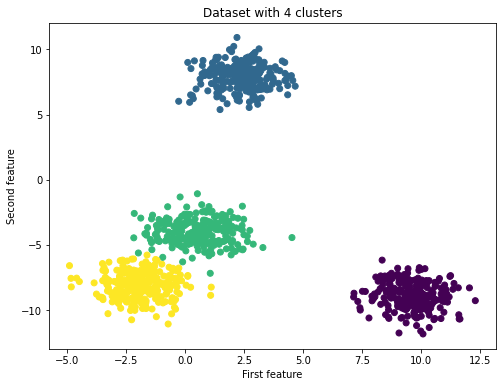

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, n_samples=1000)

fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.title("Dataset with 4 clusters")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4).fit(X)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


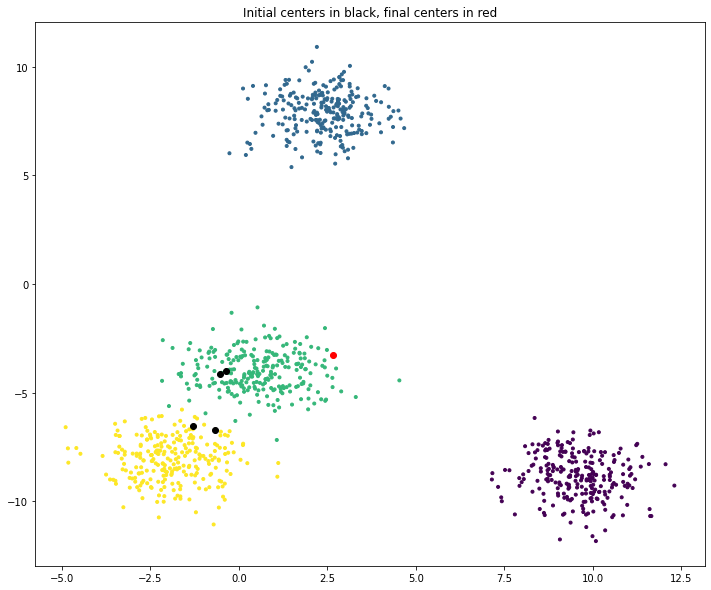

In [ ]:
plt.figure(figsize=(12,10))
plt.title("Initial centers in black, final centers in red")
plt.scatter(X[:, 0], X[:, 1], marker='.', c=y)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:,1], c='r')
plt.scatter(kmeans.intial_centroids[:, 0], kmeans.intial_centroids[:,1], c='k')
plt.show()